<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="400" height="200" />
    
    
## <font color='Black'> Deep Learning.

###Proyecto 2 - GANs.

**Nombre:** Sergio Daniel Dueñas Godinez.

**Expediente** : 739300.
    
**Profesor:** Iván Reyes Amezcua.
    
**Link Github**: https://github.com/SergioDuenass/Face-Aging

<hr>

#### Objetivos:

- Comprender los principios fundamentales de las redes generativas antagónicas (GANs) y su aplicación en el aprendizaje profundo generativo.
- Implementar una GAN básica y explorar variantes como las GANs condicionales o las CycleGANs para tareas específicas, como la generación de imágenes, traducción de imágenes o generación de texto.
- Analizar el rendimiento y las características de los modelos generados por las GANs.

#### Descripción:

Deberán seleccionar un conjunto de datos adecuado para su proyecto, que puede ser de imágenes, texto o cualquier otro tipo que permita la aplicación de GANs. Implementar una GAN, como una GAN básica, una GAN condicional o una CycleGAN, dependiendo de la naturaleza del conjunto de datos y el objetivo del proyecto. El proyecto incluirá una fase de experimentación donde los estudiantes deberán entrenar, ajustar y evaluar sus modelos. Presentar sus resultados a través de un informe escrito y una presentación, discutiendo la implementación, los desafíos encontrados, el rendimiento de sus modelos y las aplicaciones potenciales de su trabajo.
<hr>

Lo que yo haré será una cGAN, una GAN condicional, en donde se buscará a una cara, ponerla en rango de edad que va de 10 en 10.

Los datos son recopilados de https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/
Ya que estos datos son los que mejor se acoplarian a nuestro modelo, ya vienen listos con su label ya hechos

In [48]:
# Librerias a utilizar
import math
import os
import time
import numpy as np
import pickle as pkl
from PIL import Image
from glob import glob
from pathlib import Path
from scipy.io import loadmat
from datetime import datetime
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, utils


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Obtención de datos

In [1]:
!wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar
!tar -xf wiki_crop.tar

--2024-04-11 21:25:18--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 811315200 (774M) [application/x-tar]
Saving to: ‘wiki_crop.tar’

wiki_crop.tar       100%[===================>] 773.73M  15.3MB/s    in 52s     

2024-04-11 21:26:11 (14.9 MB/s) - ‘wiki_crop.tar’ saved [811315200/811315200]



### Preprocesamiento

 Esta función toma la fecha de nacimiento y el año actual como entrada, y devuelve la edad en años. La lógica adicional se encarga de manejar casos donde el cumpleaños aún no ha ocurrido en el año actual.

In [19]:
def calcular_edad(taken, dob):

    birth = datetime.fromordinal(max(int(dob) - 366, 1))

    if birth.month < 7:
        return taken - birth.year
    else:
        return taken - birth.year - 1

Esta función carga y prepara los datos de imágenes y edades para su posterior procesamiento en un formato útil y limpio.

In [20]:
def load_data(dataset='wiki', data_dir='./wiki_crop'):

    # Cargamos la metadata
    meta_path = Path(data_dir) / f'{dataset}.mat'
    meta = loadmat(meta_path)
    meta_data = meta[dataset][0, 0]

    # Cargamos la lista de los paths de los archivos
    full_path = meta_data['full_path'][0]
    full_path = [y for x in full_path for y in x]

    # Nacimientos
    dob = meta_data['dob'][0]

    # Año en que se tomó la foto
    photo_taken = meta_data['photo_taken'][0]

    # Calcular la edad
    age = [calcular_edad(photo_taken[i], dob[i]) for i in range(len(dob))]

    # limpiamos edad > 0
    clean_mapping = {pth:age for (pth, age) in zip(full_path, age) if age > 0}

    # lista de el path y la edad
    full_path = list(clean_mapping.keys())
    age = list(clean_mapping.values())

    return full_path, age


Esta función simplemente hace el escalamiento para poder utilizarlo, paso importante, ya que sino quedaría imágenes sin sentido, puros colores

In [21]:
# Escalamiento de -1 a 1
def scale(x, feature_range=(-1, 1)):

    min, max = feature_range
    x = x * (max - min) + min
    return x

Esta función convierte un tensor x a un tensor one-hot

In [22]:
# one-hot encoder
bins = [18, 29, 39, 49, 59]
def one_hot(x, bins):

    x = x.numpy()
    idxs = np.digitize(x, bins, right=True)
    idxs = idxs.reshape(-1,1)
    z = torch.zeros(len(x), len(bins)+1).scatter_(1, torch.tensor(idxs), 1)
    return z



Ahora clases para la importacion de datos

esta clase ImageAgeDataset permite cargar y acceder a muestras de imágenes junto con sus edades correspondientes desde un conjunto de datos, y opcionalmente aplicar transformaciones a estas muestras.

In [62]:
class ImageAgeDataset(Dataset):

    def __init__(self, dataset, data_dir, transform=None):

        self.data_dir = data_dir
        self.full_path, self.age = load_data(dataset, data_dir)
        self.transform = transform

    def __len__(self):
        return len(self.age)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.data_dir, self.full_path[idx]))
        age = self.age[idx]
        sample = {'image': image, 'age': age}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [24]:
class Resize(object):

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, age = sample['image'], sample['age']
        image = transforms.Resize(self.output_size)(image)
        return {'image': image, 'age': age}

In [61]:
class ToTensor(object):

    def __call__(self, sample):
        image, age = sample['image'], sample['age']
        image = transforms.ToTensor()(image)

        if image.size()[0] == 1:
            image = image.expand(3,-1,-1)
        return {'image': image, 'age': age}

In [26]:
dataset='wiki'
data_dir='./wiki_crop'
bins = [18, 29, 39, 49, 59]
img_size = 64
batch_size = 128

tfms = transforms.Compose([Resize((img_size, img_size)),
                           ToTensor()])

train_dataset = ImageAgeDataset(dataset, data_dir, transform=tfms)

# DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)

In [32]:
for batch in train_loader:
  iter(train_loader)

### Imprimimos una muestra de los datos

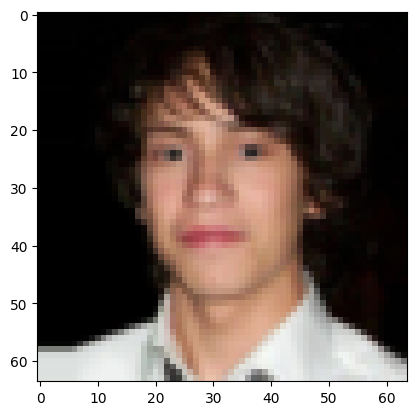

In [29]:
plt.imshow(train_dataset[100]['image'].numpy().transpose(1,2,0))

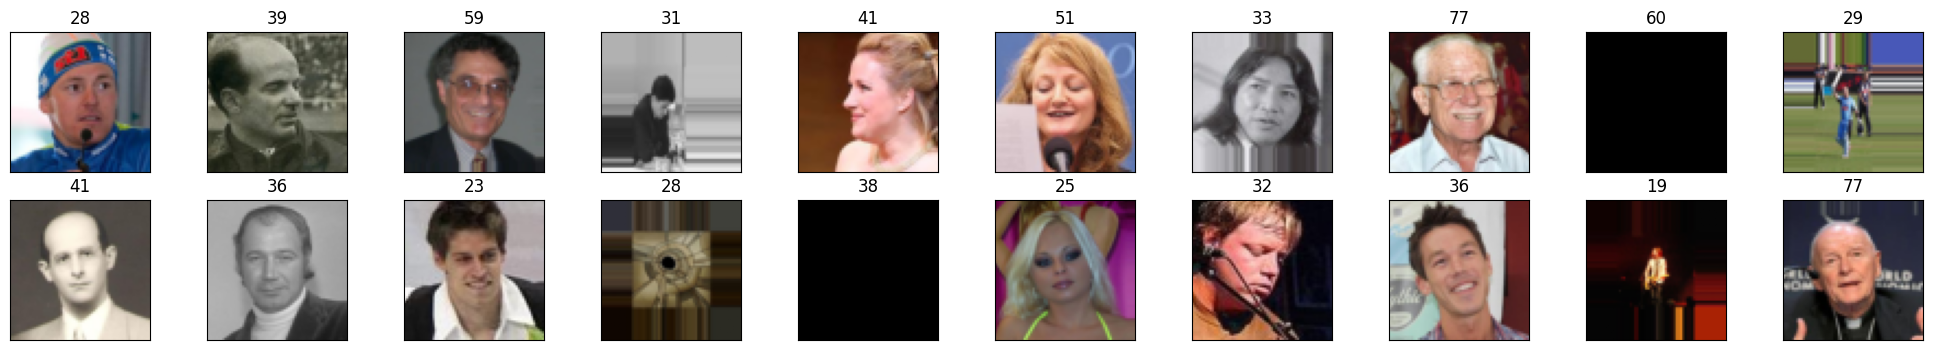

In [36]:
# Obtener un lote de imágenes de entrenamiento
for data in train_loader:
    images, labels = data['image'], data['age']
    break  # Solo necesitamos el primer lote para este ejemplo

# Mostrar las imágenes en el lote, junto con las etiquetas correspondientes
fig = plt.figure(figsize=(25, 4))
plot_size = 20
num_cols = int(plot_size / 2)  # Convertir el resultado a un entero
for idx in range(plot_size):
    ax = fig.add_subplot(2, num_cols, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx], (1, 2, 0)))
    # Imprimir la etiqueta correcta para cada imagen
    ax.set_title(str(labels[idx].item()))


### Ahora iniciamos los modelos

In [38]:
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)

    if batch_norm:
        bn = nn.BatchNorm2d(out_channels)
        layers.append(bn)

    return nn.Sequential(*layers)

#### Discriminador

In [39]:
class Discriminator(nn.Module):

    def __init__(self, y_size, conv_dim=64):

        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim
        self.y_size = y_size
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim+y_size, conv_dim * 2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        self.conv5 = conv(conv_dim*8, 1, 4, 1, 0, batch_norm=False)

    def forward(self, x, y):

        x = F.relu(self.conv1(x))
        y = y.view(-1,y.size()[-1],1,1)
        y = y.expand(-1,-1,x.size()[-2], x.size()[-1])
        x = torch.cat([x, y], 1)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)

        return x

#### Generador

In [60]:
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):

    layers = []
    t_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(t_conv)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layers)

In [59]:
class Generator(nn.Module):

    def __init__(self, z_size, y_size, conv_dim=64):
        super(Generator, self).__init__()

        self.conv_dim = conv_dim

        self.t_conv1 = deconv(z_size+y_size, conv_dim*8, 4, 1, 0)
        self.t_conv2 = deconv(conv_dim*8, conv_dim*4, 4)
        self.t_conv3 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv4 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv5 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, z, y):

        x = torch.cat([z, y], dim=1)
        x = x.view(-1, x.size()[-1], 1, 1)
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        x = F.relu(self.t_conv4(x))
        x = self.t_conv5(x)
        x = torch.tanh(x)

        return x

#### Lo combinamos

In [58]:
# Hiperparametros
conv_dim = 64
z_size = 100
y_size = 6 # clases

D = Discriminator(y_size, conv_dim)
G = Generator(z_size, y_size, conv_dim)

print(D)
print()
print(G)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(70, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

Generator(
  (t_conv1): Sequential(
    (0): ConvTranspose2d(106, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05,

#### Calculamos la perdida

In [45]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)

    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)

    labels = labels.to(device)
    criterion = nn.BCEWithLogitsLoss()

    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) #
    labels = labels.to(device)
    criterion = nn.BCEWithLogitsLoss()

    loss = criterion(D_out.squeeze(), labels)
    return loss



#### Optimizadores

In [49]:
# params
lr = 0.0002
beta1=0.5
beta2=0.999

# optimizadores para el generador y discirminador
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

#### Entrenamiento

In [50]:
def checkpoint(G, D, epoch, model, root_dir):
    target_dir = f'{root_dir}/{model}'
    os.makedirs(target_dir, exist_ok=True)
    G_path = os.path.join(target_dir, f'G_{epoch}.pkl')
    D_path = os.path.join(target_dir, f'D_{epoch}.pkl')
    torch.save(G.state_dict(), G_path)
    torch.save(D.state_dict(), D_path)

def oh_to_class(fixed_y):
    age_map = {0:'0-18',1:'19-29',2:'30-39',3:'40-49',4:'50-59',5:'60+'}
    if torch.cuda.is_available():
        fixed_y = fixed_y.cpu()
    fixed_y_idxs = fixed_y.numpy().nonzero()[1]
    fixed_y_ages = [age_map[idx] for idx in fixed_y_idxs]

    return fixed_y_ages

def save_samples_ages(samples, fixed_y, model, root_dir):
    fixed_y_ages = oh_to_class(fixed_y)
    samples_ages = {'samples': samples, 'ages': fixed_y_ages}
    target_dir = f'{root_dir}/{model}'
    os.makedirs(target_dir, exist_ok=True)
    with open(f'{target_dir}/train_samples_ages.pkl', 'wb') as f:
        pkl.dump(samples_ages, f)

In [51]:
%%time

root_dir = '/content/Age-cGAN'
model = 'GAN_1'
os.makedirs(root_dir, exist_ok=True)

# Usamos gpu
G.to(device)
D.to(device)

import pickle as pkl

num_epochs = 50

samples = []
losses = []

print_every = 300

sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
fixed_y = np.random.randint(len(bins), size=sample_size)
fixed_y = fixed_y.reshape(-1,1)
fixed_y = torch.zeros(sample_size, len(bins)+1).scatter_(1, torch.tensor(fixed_y), 1)

# Entrenamos la red
for epoch in range(num_epochs):

    for batch_i, batch in enumerate(train_loader):

        batch_size = batch['image'].size(0)

        # Las reescalamos
        real_images = scale(batch['image'])

        # one-hot age
        ages = one_hot(batch['age'], bins)


# ---------------- Discriminador ----------------
        d_optimizer.zero_grad()
# Primero entrenamos con imágenes reales
        real_images = real_images.to(device)
        ages = ages.to(device)

        D_real = D(real_images, ages)
        d_real_loss = real_loss(D_real)

# Ahora con las fakes

        # Generamos las imágenes fakes
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()

        z = z.to(device)
        fake_images = G(z, ages)

        D_fake = D(fake_images, ages)
        d_fake_loss = fake_loss(D_fake)

        # metricas
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()


# ---------------- Generador ----------------
        g_optimizer.zero_grad()

# Primero entrenamos con imágenes reales y labels volteados

        # Generamos las imágenes fakes
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        z = z.to(device)
        fake_images = G(z, ages)

        # usando labels volteados
        D_fake = D(fake_images, ages)
        g_loss = real_loss(D_fake)

        # backpropagation
        g_loss.backward()
        g_optimizer.step()

        if batch_i % print_every == 0:
            losses.append((d_loss.item(), g_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))


    # Generamos una muestra y la guardamos
    G.eval()
    fixed_z = fixed_z.to(device)
    fixed_y = fixed_y.to(device)
    samples_z = G(fixed_z, fixed_y)
    samples.append(samples_z)
    G.train()

    # checkpoint
    checkpoint(G, D, epoch, model, root_dir)

# Guardamos la muestra
save_samples_ages(samples, fixed_y, model, root_dir)


Epoch [    1/   50] | d_loss: 1.3925 | g_loss: 1.3833
Epoch [    1/   50] | d_loss: 1.5737 | g_loss: 4.5406
Epoch [    2/   50] | d_loss: 0.6322 | g_loss: 2.7557
Epoch [    2/   50] | d_loss: 0.5567 | g_loss: 2.8625
Epoch [    3/   50] | d_loss: 0.7253 | g_loss: 4.2783
Epoch [    3/   50] | d_loss: 0.4185 | g_loss: 2.2750
Epoch [    4/   50] | d_loss: 0.3956 | g_loss: 2.6836
Epoch [    4/   50] | d_loss: 0.2544 | g_loss: 4.3140
Epoch [    5/   50] | d_loss: 0.3985 | g_loss: 3.2897
Epoch [    5/   50] | d_loss: 0.3816 | g_loss: 3.1451
Epoch [    6/   50] | d_loss: 0.5116 | g_loss: 2.2838
Epoch [    6/   50] | d_loss: 0.2343 | g_loss: 3.1010
Epoch [    7/   50] | d_loss: 0.3401 | g_loss: 4.2723
Epoch [    7/   50] | d_loss: 0.1935 | g_loss: 3.5154
Epoch [    8/   50] | d_loss: 0.4041 | g_loss: 3.5860
Epoch [    8/   50] | d_loss: 0.1196 | g_loss: 4.7209
Epoch [    9/   50] | d_loss: 0.3283 | g_loss: 4.1650
Epoch [    9/   50] | d_loss: 0.0874 | g_loss: 3.8748
Epoch [   10/   50] | d_loss

#### Loss del entrenamiento

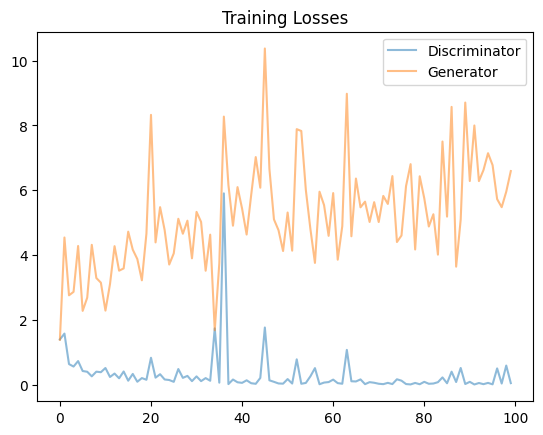

In [52]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Calamos nuestro GAN

In [57]:
def view_samples(epoch, samples, ages):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img, age in zip(axes.flatten(), samples[epoch], ages):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.set_title(age)
        im = ax.imshow(img.reshape((64,64,3)))

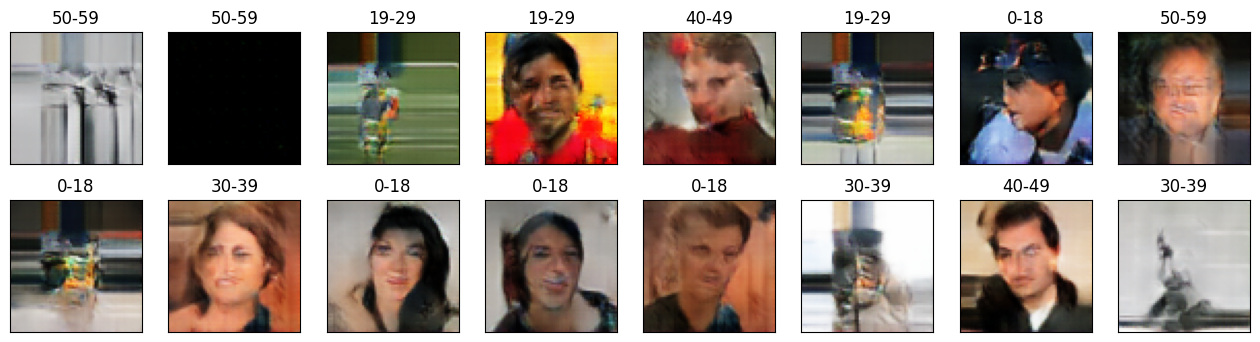

In [56]:
fixed_y_ages = oh_to_class(fixed_y)
_ = view_samples(-1, samples, fixed_y_ages)

Vemos que las imágenes generadas que sí parecen caras humanas, si las pone bien, exceptuando las que no parecen